In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# importing dataset
df = pd.read_csv('content/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:

# defining shapiro normality Test
def shapiro_normality_test(x:pd.Series):
    """
    Performs the Shapiro-Wilk Normality Test to check whether 
    the given data follows normal distribution of not.
    """
    
    statistic,p_value = stats.shapiro(x)
    if p_value > 0.05:
        print("The data is normally distributed")
    else:
        print("The data is not normally distributed")

    print(f"statistic={statistic.round(decimals=3)}")
    print(f"p_value={p_value.round(decimals=3)}")
    

In [3]:
# categorizing the bmi values as underweight,normal,overweight and obsesity.
df.sort_values(by='bmi',ascending=True).reset_index(drop=True,inplace=True)

conditions = [
    (df['bmi']<18.5),                       #underweight
    (df['bmi']>=18.5) & (df['bmi']<=25),    #normal
    (df['bmi']>25) & (df['bmi']<=29.9),     #overweight 
    (df['bmi']>29.9)]                       #obesity 

categories = ['underweight','normal','overweight','obesity']

df['bmi_category'] = np.select(conditions,categories,default='unknown')


df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obesity
2,28,male,33.000,3,no,southeast,4449.46200,obesity
3,33,male,22.705,0,no,northwest,21984.47061,normal
4,32,male,28.880,0,no,northwest,3866.85520,overweight


In [4]:
df['bmi_category'].value_counts().to_frame().reset_index()

,bmi_category,count
0,obesity,716
1,overweight,375
2,normal,227
3,underweight,20


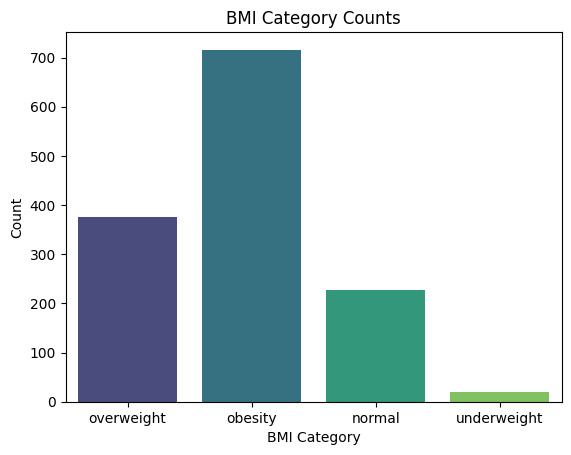

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.countplot(x='bmi_category',data=df,palette="viridis")
plt.title('BMI Category Counts')
plt.xlabel('BMI Category')
plt.ylabel('Count') 
plt.show()


In [6]:
# extracting medical charges for each bmi category

normalweight_charges = df.query('bmi_category == "normal"')['charges']
overweight_charges = df.query('bmi_category == "overweight"')['charges']
obesity_charges = df.query('bmi_category == "obesity"')['charges']

# shapiro normality test for normal charges
shapiro_normality_test(normalweight_charges)
# shapiro normality test for overweight charges
shapiro_normality_test(overweight_charges)
# shapiro normality test for obesity charges
shapiro_normality_test(obesity_charges)    

The data is not normally distributed
statistic=0.918
p_value=0.0
The data is not normally distributed
statistic=0.899
p_value=0.0
The data is not normally distributed
statistic=0.805
p_value=0.0


In [7]:

def get_bootstrap_samples(data:pd.Series,n_resamples:int):
    """
    Generates bootstrap samples for given dataset

    Args:
        data:pd.Series
        n_resamples:int (total samples to generate)
    Returns:
        bootstrap_sample:numpy.ndarray
    """
    bootstrap_samples = stats.bootstrap(data=(data,),
                                        statistic=np.mean,
                                        confidence_level=0.95, # 5% significance level
                                        n_resamples=n_resamples,
                                        axis=0).bootstrap_distribution
    return bootstrap_samples

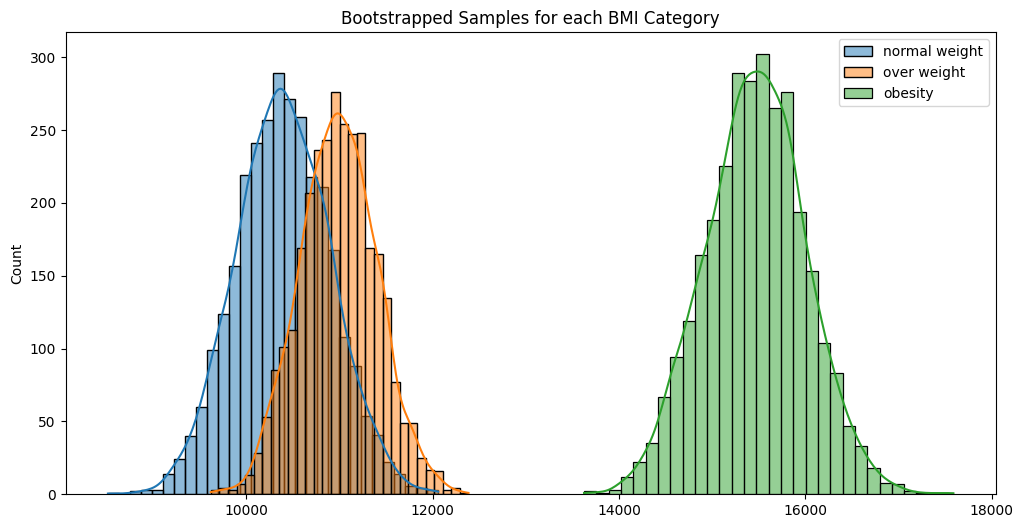

In [8]:
# get bootstrap samples for the charges based on bmi category
normalweight_bootstrap_samples = get_bootstrap_samples(normalweight_charges,3000)

overweight_bootstrap_samples = get_bootstrap_samples(overweight_charges,3000)

obesity_bootstrap_samples = get_bootstrap_samples(obesity_charges,3000)


# plot the histogram of the bootstrap samples
plt.figure(figsize=(12,6))
sns.histplot(normalweight_bootstrap_samples,bins=30,edgecolor='black',kde=True,label='normal weight')
sns.histplot(overweight_bootstrap_samples,bins=30,edgecolor='black',kde=True,label='over weight')
sns.histplot(obesity_bootstrap_samples,bins=30,edgecolor='black',kde=True,label='obesity')
plt.legend()
plt.title("Bootstrapped Samples for each BMI Category")
plt.show()


In [9]:
shapiro_normality_test(normalweight_bootstrap_samples)
shapiro_normality_test(overweight_bootstrap_samples)
shapiro_normality_test(obesity_bootstrap_samples)

The data is normally distributed
statistic=1.0
p_value=0.91
The data is normally distributed
statistic=0.999
p_value=0.596
The data is normally distributed
statistic=0.999
p_value=0.453


In [10]:
# retrieving the population mean charges
pop_mean = df['charges'].mean()

# defining the function which performs T-Test
def one_sample_t_test(sample: pd.Series, pop_mean: float) -> tuple:
    """
    Performs a one-sample t-test to determine if there is a significant difference 
    between the population mean charges and the sample mean charges.

    Args:
        sample (pd.Series): A sample of data to compare to the population mean.
        pop_mean (float): The population mean to compare the sample to.
    """
    t_statistic, p_value = stats.ttest_1samp(sample, pop_mean)
    t_statistic = round(t_statistic, 3)
    p_value = round(p_value, 3)
    print(f"t_statistic={t_statistic}")
    print(f"p_value={p_value}")
    print(f"There is a {'no ' if p_value >= 0.05 else ''}significant difference "
          f"between the population mean charges and the sample mean charges.")


In [11]:
# one sample t-test for normal weight charges
one_sample_t_test(normalweight_bootstrap_samples,                 # sample data
                  pop_mean)                             # population mean


t_statistic=-314.646
p_value=0.0
There is a significant difference between the population mean charges and the sample mean charges.


In [12]:
# one sample t-test for overweight charges
one_sample_t_test(overweight_bootstrap_samples,pop_mean)


t_statistic=-303.768
p_value=0.0
There is a significant difference between the population mean charges and the sample mean charges.


In [13]:
# one sample t-test for obesity charges
one_sample_t_test(obesity_bootstrap_samples,pop_mean)

t_statistic=224.026
p_value=0.0
There is a significant difference between the population mean charges and the sample mean charges.


In [14]:
# performing levene's test to check for equal variances
from scipy.stats import levene

statistic, p_value = levene(normalweight_bootstrap_samples, overweight_bootstrap_samples)

print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value.round())

Levene's test statistic: 100.97717635954466
Levene's test p-value: 0.0


In [15]:
t_statistic,p_value = stats.ttest_ind(normalweight_bootstrap_samples,
                                      overweight_bootstrap_samples,
                                      equal_var=False)


print(f"t_statistic={t_statistic.round(decimals=3)}")
print(f"p_value={p_value.round(decimals=3)}")
if p_value < 0.05:
    print("There is a significant difference between the mean charges of normal weight and overweight")
else:
    print("There is no significant difference between the mean charges of normal weight and overweight")
    
    

t_statistic=-50.093
p_value=0.0
There is a significant difference between the mean charges of normal weight and overweight


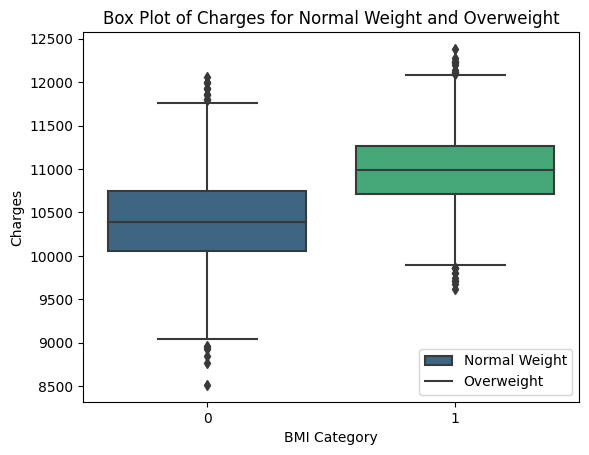

In [16]:
# comparing the box plots
sns.boxplot(data=[normalweight_bootstrap_samples,overweight_bootstrap_samples],
            showfliers=True,
            palette='viridis')
plt.legend(labels=['Normal Weight','Overweight'])
plt.title('Box Plot of Charges for Normal Weight and Overweight')
plt.xlabel('BMI Category')
plt.ylabel('Charges')
plt.show()



In [17]:
# creating confidence interval for the difference between the means of the two groups

mean_diff = abs(normalweight_bootstrap_samples - overweight_bootstrap_samples)

confidence_interval = stats.t.interval(confidence=0.95,
                                       df=len(mean_diff)-1,
                                       loc=t_statistic,
                                       scale=stats.sem(mean_diff))
print(f"confidence interval={confidence_interval}")

confidence interval=(-68.19223750472841, -31.994460319385944)


In [18]:

# Assuming you have the mean, standard deviation, and sample size for each group

# calculating mean difference b/w normal and overweight bmi charges
mean_difference = abs(np.mean(normalweight_bootstrap_samples) - np.mean(overweight_bootstrap_samples))

# constructing pooled standard deviation
pooled_sd = np.sqrt(((len(normalweight_bootstrap_samples) - 1) * np.var(normalweight_bootstrap_samples) + (len(overweight_bootstrap_samples) - 1) * np.var(overweight_bootstrap_samples)) / (len(normalweight_bootstrap_samples) + len(overweight_bootstrap_samples) - 2))

# calculating cohens d
cohens_d = mean_difference / pooled_sd

print("Cohen's d:", cohens_d)

Cohen's d: 1.2936203286390833


In [19]:
from statsmodels.stats.power import tt_solve_power

# Assuming you have the effect size, significance level, and desired power
effect_size = 1.25  # Cohen's d
alpha = 0.05        # Significance level
power = 0.8         # Power

# Calculate the required sample size for each group
nobs = tt_solve_power(effect_size=effect_size, 
                      alpha=alpha,
                      power=power,
                      alternative='two-sided')

print("Required sample size per group:", nobs)

Required sample size per group: 7.171635310997955
